# Bibliotecas

In [2]:
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow import keras 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras import backend as K
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from keras.models import load_model
from google.colab import drive
from imutils import paths
import tensorflow as tf
import os
import gc
import glob
import numpy as np
import cv2
import random
import imutils
import matplotlib

Using TensorFlow backend.


# Carregando Dados

In [3]:
# Montando a partição Drive
drive.mount('/content/drive')

#----Atualizar este path para o raiz do imagens.zip
home_path = 'drive/My Drive/2019/headhunter/mobit/anexos'
#-----------

q1_path = home_path + '/questao1/'
q2_path = home_path + '/questao2/'
q3_path = home_path + '/questao3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


#Questões & Respostas

## 1. Utilizando OpenCV, conte a quantidade de objetos na imagem objetos.png

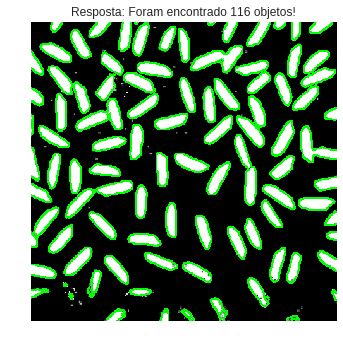

In [5]:
# Carregando imagem
img_path = q1_path + 'objetos.png'
original = cv2.imread(img_path)

# Aplicar Filtros
med = cv2.medianBlur(original, 5)
gauss = cv2.GaussianBlur(med, (5,5), 2)


# Detectar bordas com Canny
canny = cv2.Canny(gauss, 50, 150)

# Contando contornos
_, contornos, _ = cv2.findContours(canny.copy(), cv2.RETR_EXTERNAL, 
                                   cv2.CHAIN_APPROX_SIMPLE)

# Destacando contornos encontrados
resultado = original.copy()
cv2.drawContours(resultado,contornos,-1,(0,255,0), 2)

# Plot
plt.imshow(resultado)
plt.title('Resposta: Foram encontrado {} objetos!'.format(len(contornos)))
plt.axis('off')
plt.show()

##2. Dada a imagem pessoas.jpg, conte a quantidade de pessoas

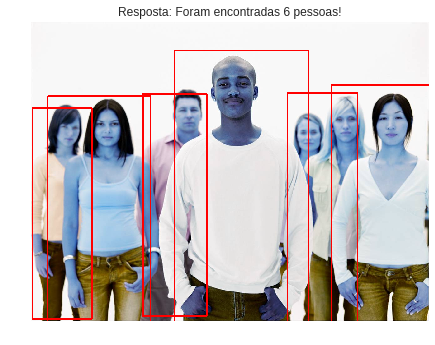

In [6]:
# Localizando paths
img_path = q2_path + 'pessoas.jpg'
lbl_path = q2_path + 'coco.names'

# Tiny
cfg_path = q2_path + 'yolov3-tiny.cfg'
mdl_path = q2_path + 'yolov3-tiny.weights'

# YOLOFull
# cfg_path = q2_path + 'yolov3.cfg'
# mdl_path = q2_path + 'yolov3.weights'

# Inicializando parêmetros TIny
confThreshold = 0.4  #Limiar de confiabilidade
# Padrões 320, 416 ou 608
inpWidth = 320  #Largura da imagem de entrada
inpHeight = 320 #Altura da imagem de entrada

# # YOLOFull
# confThreshold = 0.8
# inpWidth = 608
# inpHeight = 608

# Carregando o rótulos
classes = None
with open(lbl_path, 'rt') as f:
  classes = f.read().rstrip('\n').split('\n')
  
# Carregando a YOLO
net = cv2.dnn.readNetFromDarknet(cfg_path, mdl_path)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

# Carregando imagem
original = cv2.imread(img_path)

# Criando o tensor 4D.
blob = cv2.dnn.blobFromImage(original, 1/255, (inpWidth, inpHeight), 
                             [0,0,0], 1, crop=False)

# Inserindo o tensor na entrada da Convnet
net.setInput(blob)

# Identificando as camadas finais para nortear o Forward
layersNames = net.getLayerNames()
names = [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]
# Proceder o Forward
outs = net.forward(names)

# Filtra detecções de baixa confiabilidade em relação ao limiar.
frameHeight = original.shape[0]
frameWidth = original.shape[1]
classIds = []
confidences = []
boxes = []
for out in outs:
    for detection in out:
        scores = detection[5:]
        classId = np.argmax(scores)
        confidence = scores[classId]
        if confidence > confThreshold:
            # Montando quadros.
            center_x = int(detection[0] * frameWidth)
            center_y = int(detection[1] * frameHeight)
            width = int(detection[2] * frameWidth)
            height = int(detection[3] * frameHeight)
            left = int(center_x - width / 2)
            top = int(center_y - height / 2)
            classIds.append(classId)
            confidences.append(float(confidence))
            boxes.append([left, top, width, height])

# Saber quantidade de pessoas encontradas
qnt_pessoas = classIds.count(classes.index('person'))

# Destacar a pessoas encontradas
for i in range(len(classIds)):
#     if 'person' == classes[classIds[i]]:
    box = boxes[i]
    left = box[0]
    top = box[1]
    width = box[2]
    height = box[3]
    right = left + width
    bottom = top + height
    cv2.rectangle(original, (left, top), (right, bottom), (255, 0, 0),4)

# Plot
plt.imshow(original)
plt.title('Resposta: Foram encontradas {} pessoas!'.format(qnt_pessoas))
plt.axis('off')
plt.show()

##3. Treine um classificador de tipos de carros utilizando DeepLearning.

* Utilize o banco de imagens BMW-10 dataset, disponível em: Cars Dataset
(https://ai.stanford.edu/~jkrause/cars/car_dataset.html);
* O classificador deve diferenciar somente as classes 3,4 e 5 do banco BMW-10 e
uma classe classe indefinida. Assim, o classificador deve conseguir classificar as
classes 3, 4, 5 e indefinida;
* Separe o banco em 70 % para treinamento e 30% para teste;
* Pode-se utilizar scripts que auxiliem no processo:
Exemplo: https://www.pyimagesearch.com/2017/12/11/image-classification-withkeras-
and-deep-learning/

### Localizando paths

In [0]:
rotulos    = ['Classe_3','Classe_4','Classe_5']
img_path   = q3_path + 'bmw10_custom/bmw10_ims/'
save_model = q3_path + 'bmw.model'
save_result= q3_path + 'resultado.png'
save_plot  = q3_path + 'plot.png'
ex_path    = q3_path + 'examplos_carros/'


### LeNet

In [0]:
class LeNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model
		model = Sequential()
		inputShape = (height, width, depth)

		# if we are using "channels first", update the input shape
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)

		# first set of CONV => RELU => POOL layers
		model.add(Conv2D(20, (5, 5), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

		# second set of CONV => RELU => POOL layers
		model.add(Conv2D(50, (5, 5), padding="same"))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(500))
		model.add(Activation("relu"))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

### Treino

[INFO] loading images...
[INFO] compiling model...
[INFO] training network...
Epoch 1/200
17/17 [==============================] - 5s 278ms/step - loss: 0.5920 - acc: 0.7316 - val_loss: 0.5632 - val_acc: 0.7500
Epoch 2/200
17/17 [==============================] - 0s 20ms/step - loss: 0.5629 - acc: 0.7500 - val_loss: 0.5631 - val_acc: 0.7500
Epoch 3/200
17/17 [==============================] - 0s 19ms/step - loss: 0.5619 - acc: 0.7500 - val_loss: 0.5633 - val_acc: 0.7500
Epoch 4/200
17/17 [==============================] - 0s 18ms/step - loss: 0.5618 - acc: 0.7500 - val_loss: 0.5641 - val_acc: 0.7500
Epoch 5/200
17/17 [==============================] - 0s 19ms/step - loss: 0.5611 - acc: 0.7500 - val_loss: 0.5646 - val_acc: 0.7500
Epoch 6/200
17/17 [==============================] - 0s 18ms/step - loss: 0.5617 - acc: 0.7500 - val_loss: 0.5653 - val_acc: 0.7500
Epoch 7/200
17/17 [==============================] - 0s 19ms/step - loss: 0.5613 - acc: 0.7500 - val_loss: 0.5654 - val_acc: 0.75

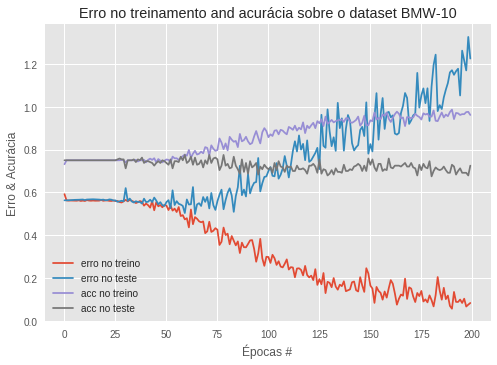

In [63]:
# set the matplotlib backend so figures can be saved in the background
matplotlib.use("Agg")
# initialize the number of epochs to train for, initia learning rate,
# and batch size
EPOCHS = 200
INIT_LR = 1e-3
BS = 8
NUM_LBL = 4

# initialize the data and labels
print("[INFO] loading images...")
data = []
labels = []

# grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images(img_path)))
random.seed(42)
random.shuffle(imagePaths)

# loop over the input images
for imagePath in imagePaths:
  # load the image, pre-process it, and store it in the data list
  image = cv2.imread(imagePath)
  image = cv2.resize(image, (56, 56))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = img_to_array(image)
  data.append(image)

  # extract the class label from the image path and update the
  # labels list
  label = imagePath.split(os.path.sep)[-2]
  label = rotulos.index(label)+1 if label in rotulos else 0
  labels.append(label)
  
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# partition the data into training and testing splits using 70% of
# the data for training and the remaining 30% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.30, random_state=42)

# convert the labels from integers to vectors
trainY = to_categorical(trainY, num_classes=NUM_LBL)
testY = to_categorical(testY, num_classes=NUM_LBL)

# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	horizontal_flip=True, fill_mode="nearest")

# initialize the model
print("[INFO] compiling model...")
model = LeNet.build(width=56, height=56, depth=1, classes=NUM_LBL)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the network
print("[INFO] training network...")
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS, verbose=1)

# save the model to disk
print("[INFO] serializing network...")
model.save(save_model)

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="erro no treino")
plt.plot(np.arange(0, N), H.history["val_loss"], label="erro no teste")
plt.plot(np.arange(0, N), H.history["acc"], label="acc no treino")
plt.plot(np.arange(0, N), H.history["val_acc"], label="acc no teste")
plt.title("Erro no treinamento and acurácia sobre o dataset BMW-10")
plt.xlabel("Épocas #")
plt.ylabel("Erro & Acurácia")
plt.legend(loc="lower left")
plt.savefig(save_plot)

### Teste

#####Defnição

In [89]:
def teste(amostra_path):
  # load the image
  print("[INFO] loading image {}...".format(amostra_path
                                            .split(os.path.sep)[-1]))
  image = cv2.imread(amostra_path)
  orig = image.copy()
  # pre-process the image for classification
  image = cv2.resize(image, (56, 56))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = image.astype("float") / 255.0
  image = img_to_array(image)
  image = np.expand_dims(image, axis=0)

  # load the trained convolutional neural network
  print("[INFO] loading network...")
  model = load_model(save_model)

  # classify the input image
  na, c3, c4, c5 = model.predict(image)[0]
  y_hat=[na, c3, c4, c5]
  print(y_hat)
  # build the label
  acc = max(y_hat)
  idx = y_hat.index(acc)-1
#   print('max_id_{}'.format(idx))
  if idx > -1:
    label = rotulos[idx] 
  else:
    label = 'Indefida'
  label = "{}: {:.2f}%".format(label, acc * 100)

  # draw the label on the image
  output = imutils.resize(orig, width=400)
  cv2.putText(output, label, (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,
              0.7, (0, 255, 0), 2)
  return output

SyntaxError: ignored

#####Execução de testes e apresentação de resultados

['Indefinida', 'Classe_3', 'Classe_4', 'Classe_5']
[INFO] loading image bmw3.jpg...
[INFO] loading network...
[1.9097061e-07, 0.9999802, 1.781742e-05, 1.6811688e-06]
max_id_0
[INFO] loading image bmw4.jpg...
[INFO] loading network...
[1.0898915e-12, 3.5602605e-07, 0.99996173, 3.7896898e-05]
max_id_1
[INFO] loading image bmw5.jpg...
[INFO] loading network...
[0.00044158872, 0.0009858421, 0.0017343276, 0.9968382]
max_id_2
[INFO] loading image fusc.jpg...
[INFO] loading network...
[0.9999728, 2.719648e-05, 3.3351892e-09, 1.744239e-10]
max_id_-1
[INFO] getting plot...


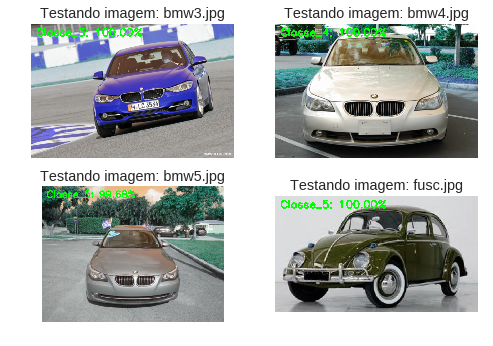

In [88]:
resultado = []
print(['Indefinida']+rotulos)
ex_test = list(paths.list_images(ex_path))
for p in ex_test:
  output = teste(p)
  resultado.append(output)

print("[INFO] getting plot...")  
plt.subplot(221)
plt.imshow(resultado[0])
plt.title('Testando imagem: {}'.format(ex_test[0]
                                          .split(os.path.sep)[-1]))
plt.axis('off')

plt.subplot(222)
plt.imshow(resultado[1])
plt.title('Testando imagem: {}'.format(ex_test[1]
                                          .split(os.path.sep)[-1]))
plt.axis('off')

plt.subplot(223)
plt.imshow(resultado[2])
plt.title('Testando imagem: {}'.format(ex_test[2]
                                          .split(os.path.sep)[-1]))
plt.axis('off')

plt.subplot(224)
plt.imshow(resultado[3])
plt.title('Testando imagem: {}'.format(ex_test[3]
                                          .split(os.path.sep)[-1]))
plt.axis('off')

plt.show()
plt.savefig(save_result)

In [82]:
a = [1.9097061e-07, 0.9999802, 1.781742e-05, 1.6811688e-06]
a.index(max(a))
rotulos[a.index(max(a))-1]
len(a)

4